In [26]:
import os
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

#from jsonschema.benchmarks.contains import beginning

Nr 
Panel 
1. 
Copper Indium Gallium Selenide (CIGS), a flexible 
module; 
nominal efficiency Specifications 
12.7% specs 
2. 
Cadmium Telluride (CdTe), a lower cost module; 
12.0% specs 
3. 
Polycrystalline Silicon (Poly-Si), the most commonly 
used technology; 
15.5% specs 
4. 
Interdigitated Back Contact monocrystalline silicon, 
charge extraction located at the back of the cell;  
21.5% specs 
5. 
Heterojunction Intrinsic Layer Monocrystalline Silicon 
(HIT Si), highest lab-tested efficiency; 
19.4% specs 
6. 
Copper Indium Gallium Selenide (CIGS) with reflective 
backing; 
14.7% specs

In [27]:
def get_selected_months(years=None, months=None):
    """
    Generate a list of selected months based on user input for years and months.
    
    Parameters:
        years (list of int): List of years to include (e.g., [2017, 2018]).
        months (list of int): List of months to include (e.g., [1, 2, 3]).
        
    Returns:
        list of str: List of selected year_month combinations (e.g., ['2017_01', '2017_02']).
    """
    if years is None:
        years = [2017]  # Default year
    if months is None:
        months = range(1, 13)  # Default to all months

    selected_months = [f"{year}_{str(month).zfill(2)}" for year in years for month in months]
    return selected_months

In [28]:
def load_and_sync_data(base_path, selected_months, selected_csvs, debug=False):
    base_path = Path(base_path)
    if not base_path.is_dir():
        raise FileNotFoundError(f"The base path does not exist: {base_path}")

    # Dictionary to store DataFrames from each source
    source_dataframes = {}

    for csv_type in selected_csvs:
        combined_source_data = []

        for month in selected_months:
            year, month_number = month.split('_')
            year_folder = f"{year}_V3"
            month_folder = f"{year}_{month_number}"
            month_path = base_path / year_folder / month_folder

            if not month_path.is_dir():
                if debug:
                    print(f"Skipping non-existent directory: {month_path}")
                continue

            # Determine the correct file name for the source
            file_name_with_space = f"{csv_type}- {month_folder}.csv"
            file_name_without_space = f"{csv_type}-{month_folder}.csv"

            file_path = None
            if csv_type == "LightSpectra":
                # Handle LightSpectra's unique naming format
                file_path_with_space = month_path / file_name_with_space
                file_path_without_space = month_path / file_name_without_space
                if file_path_with_space.exists():
                    file_path = file_path_with_space
                elif file_path_without_space.exists():
                    file_path = file_path_without_space
            else:
                file_path = month_path / file_name_without_space

            if file_path and file_path.exists():
                try:
                    data_frame = pd.read_csv(file_path, low_memory=False)

                    # -------------------
                    # Standardize date/time columns
                    # -------------------
                    data_frame["Year"] = data_frame.get("Date[year]", year)
                    data_frame["Month"] = data_frame.get("Date[month]", month_number)
                    data_frame["Day"] = data_frame.get("Date[day]")
                    data_frame["Weekday"] = data_frame.get("Date[weekday]")

                    if "Time[hh:mm:ss]" in data_frame.columns:
                        data_frame["Time"] = data_frame["Time[hh:mm:ss]"]
                        data_frame.drop(columns=["Time[hh:mm:ss]"], errors="ignore", inplace=True)

                    data_frame.drop(
                        columns=[col for col in data_frame.columns if col.startswith("Date[")],
                        errors="ignore",
                        inplace=True
                    )

                    data_frame["Source"] = csv_type  # (optional metadata)
                    combined_source_data.append(data_frame)

                except Exception as e:
                    if debug:
                        print(f"Error loading file {file_path}: {e}")
            else:
                if debug:
                    print(f"File not found: {file_path}")

        # Concatenate all data for the current source
        if combined_source_data:
            source_dataframes[csv_type] = pd.concat(combined_source_data, ignore_index=True)

    # -------------------
    # Merge (inner join) across all sources on "AbsTime[s]"
    # -------------------
    synced_data = None
    for source, df in source_dataframes.items():
        if synced_data is None:
            synced_data = df
        else:
            synced_data = pd.merge(
                synced_data,
                df,
                on='AbsTime[s]',
                how='inner',
                suffixes=('', f'_{source}')
            )

    # -------------------
    # Consolidate duplicate columns
    # -------------------
    if synced_data is not None:
        for col in ["Year", "Month", "Day", "Time", "Weekday"]:
            # Gather all columns that start with "Year", "Month", etc.
            cols_to_merge = [c for c in synced_data.columns if c.startswith(col)]
            if len(cols_to_merge) > 1:
                # Fill "master" col with first non-NaN going left->right
                synced_data[col] = synced_data[cols_to_merge].bfill(axis=1).iloc[:, 0]
                # Drop duplicates except for the original "col"
                cols_to_drop = [c for c in cols_to_merge if c != col]
                synced_data.drop(columns=cols_to_drop, inplace=True, errors="ignore")

        # Remove the "Source" columns if no longer needed
        synced_data.drop(
            columns=[col for col in synced_data.columns if "Source" in col],
            errors="ignore",
            inplace=True
        )

        # Remove exact duplicated columns (rare leftover edge case)
        synced_data = synced_data.loc[:, ~synced_data.columns.duplicated()]

        return synced_data

    # If no data was found at all
    return pd.DataFrame()


if __name__ == "__main__":
    # Base path to the dataset
    base_path = "../../OneDrive - HvA/Jaar_4/PV systems modeling and analysis/Data/data_folder"
    base_path_bono = "../../school/4e jaar/PV systems modeling and analysis/Data/data_folder"

    # Specify months and sources to include
    selected_months = get_selected_months(years=[2021], months=[5,6])
    selected_csvs = ["SolarFieldData"]

    # Load and synchronize data
    synced_df = load_and_sync_data(base_path, selected_months, selected_csvs, debug=True)

    # Display the synchronized DataFrame
    print("\nSynchronized DataFrame:")
    print(synced_df.head())

    # # Save the synchronized data for later use (optional)
    # synced_df.to_csv("synced_data_january_2017_2018.csv", index=False)
    # print("Synchronized data saved to synced_data_january_2017_2018.csv")



Synchronized DataFrame:
   AbsTime[s]  Act Air Density (WeatherStation)  \
0  3828816000                               NaN   
1  3828816300                               NaN   
2  3828816600                               NaN   
3  3828816900                               NaN   
4  3828817200                               NaN   

   Act Wind Direction (WeatherStation)  \
0                                  NaN   
1                                  NaN   
2                                  NaN   
3                                  NaN   
4                                  NaN   

   Act Wind Measurement Quality (WeatherStation)  \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4                                            NaN   

   Act Wind Speed [km/h] (WeatherStation)  \
0                                     NaN   
1           

In [29]:
synced_df

,AbsTime[s],Act Air Density (WeatherStation),Act Wind Direction (WeatherStation),Act Wind Measurement Quality (WeatherStation),Act Wind Speed [km/h] (WeatherStation),Avg Absolute Air Pressure (WeatherStation),Avg Air Temperature (WeatherStation),Avg Dewpoint Temperature (WeatherStation),Avg Relative Humidity (WeatherStation),Avg Wind Speed [km/h] (WeatherStation),...,Clear light (LAD Sensor 12),Infrared light (LAD Sensor 12),Temperature [°C] (LAD Sensor 12),Gain (LAD Sensor 12),Integration time (LAD Sensor 12),Year,Month,Day,Weekday,Time
0,3828816000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2021,May,1,Saturday,00:00:00
1,3828816300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,6.8,0.0,192.0,2021,May,1,Saturday,00:05:00
2,3828816600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,6.5,0.0,192.0,2021,May,1,Saturday,00:10:00
3,3828816900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,6.5,0.0,192.0,2021,May,1,Saturday,00:15:00
4,3828817200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,6.5,0.0,192.0,2021,May,1,Saturday,00:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17563,3834084900,1.221169,0.0000,100.0,0.000000,1015.896,15.08232,12.95173,87.10642,1.201355,...,0.0,0.0,15.2,0.0,192.0,2021,June,30,Wednesday,23:35:00
17564,3834085200,1.221149,0.0000,100.0,0.000000,1015.932,15.06875,12.92241,87.01555,1.291014,...,0.0,0.0,15.2,0.0,192.0,2021,June,30,Wednesday,23:40:00
17565,3834085500,1.221200,0.0000,100.0,0.000000,1015.962,15.04553,12.88310,86.92194,1.174879,...,0.0,0.0,15.2,0.0,192.0,2021,June,30,Wednesday,23:45:00
17566,3834085800,1.220924,0.0000,100.0,0.000000,1015.987,15.09856,12.91005,86.77888,0.000000,...,0.0,0.0,15.2,0.0,192.0,2021,June,30,Wednesday,23:50:00


In [30]:
# 1) Maandnaam omzetten naar maandnummer
month_map = {
    'January': '01',
    'February': '02',
    'March': '03',
    'April': '04',
    'May': '05',
    'June': '06',
    'July': '07',
    'August': '08',
    'September': '09',
    'October': '10',
    'November': '11',
    'December': '12'
}
synced_df['Month_num'] = synced_df['Month'].map(month_map)

# 2) De kolommen Year, Month_num, Day en Time samenvoegen tot een datumstring
synced_df['datetime_str'] = (
    synced_df['Year'].astype(str) + '-' +
    synced_df['Month_num'].astype(str) + '-' +
    synced_df['Day'].astype(str) + ' ' +
    synced_df['Time'].astype(str)
)

# 3) Deze string parsen naar een datetime-kolom
synced_df['datetime'] = pd.to_datetime(synced_df['datetime_str'], format='%Y-%m-%d %H:%M:%S')

# 4) Zet deze nieuwe kolom als index van je DataFrame
synced_df.set_index('datetime', inplace=True)

# 5) (Optioneel) Opruimen: als je de losse kolommen niet meer nodig hebt:
synced_df.drop(columns=['Month_num', 'datetime_str'], inplace=True)

synced_df

,AbsTime[s],Act Air Density (WeatherStation),Act Wind Direction (WeatherStation),Act Wind Measurement Quality (WeatherStation),Act Wind Speed [km/h] (WeatherStation),Avg Absolute Air Pressure (WeatherStation),Avg Air Temperature (WeatherStation),Avg Dewpoint Temperature (WeatherStation),Avg Relative Humidity (WeatherStation),Avg Wind Speed [km/h] (WeatherStation),...,Clear light (LAD Sensor 12),Infrared light (LAD Sensor 12),Temperature [°C] (LAD Sensor 12),Gain (LAD Sensor 12),Integration time (LAD Sensor 12),Year,Month,Day,Weekday,Time
datetime,,,,,,,,,,,,,,,,,,,,,
2021-05-01 00:00:00,3828816000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2021,May,1,Saturday,00:00:00
2021-05-01 00:05:00,3828816300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,6.8,0.0,192.0,2021,May,1,Saturday,00:05:00
2021-05-01 00:10:00,3828816600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,6.5,0.0,192.0,2021,May,1,Saturday,00:10:00
2021-05-01 00:15:00,3828816900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,6.5,0.0,192.0,2021,May,1,Saturday,00:15:00
2021-05-01 00:20:00,3828817200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,6.5,0.0,192.0,2021,May,1,Saturday,00:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-30 23:35:00,3834084900,1.221169,0.0000,100.0,0.000000,1015.896,15.08232,12.95173,87.10642,1.201355,...,0.0,0.0,15.2,0.0,192.0,2021,June,30,Wednesday,23:35:00
2021-06-30 23:40:00,3834085200,1.221149,0.0000,100.0,0.000000,1015.932,15.06875,12.92241,87.01555,1.291014,...,0.0,0.0,15.2,0.0,192.0,2021,June,30,Wednesday,23:40:00
2021-06-30 23:45:00,3834085500,1.221200,0.0000,100.0,0.000000,1015.962,15.04553,12.88310,86.92194,1.174879,...,0.0,0.0,15.2,0.0,192.0,2021,June,30,Wednesday,23:45:00


In [31]:
# AbsTime[s],
# Act Air Density (WeatherStation),
# Act Wind Direction (WeatherStation),
# Act Wind Measurement Quality (WeatherStation),
# Act Wind Speed [km/h] (WeatherStation),
# Avg Absolute Air Pressure (WeatherStation),
# Avg Air Temperature (WeatherStation),
# Avg Dewpoint Temperature (WeatherStation),
# Avg Relative Humidity (WeatherStation),
# Avg Wind Speed [km/h] (WeatherStation),
# Precipitation Intensity [mm/h] (WeatherStation),
# Precipitation Type (WeatherStation),
# Module #_1 (Solarpanel parameters),
# Vmpp[V]_1 (Solarpanel parameters),
# Impp[A]_1 (Solarpanel parameters),
# Pmpp[W]_1 (Solarpanel parameters),
# Voc[V]_1 (Solarpanel parameters),
# Isc[A]_1 (Solarpanel parameters),
# FF[%]_1 (Solarpanel parameters),
# G[W/mï½²]_1 (Solarpanel parameters),
# Tmodul[ï½°C]_1 (Solarpanel parameters),
# G_pyranometer[W/mï½²]_1 (Solarpanel parameters),
# V Range_1 (Solarpanel parameters),
# I Range_1 (Solarpanel parameters),
# Scan Rate[S/sec.]_1 (Solarpanel parameters),
# Observed Efficiency_1 (Solarpanel parameters),
# Year,Month,Day,Weekday,Time

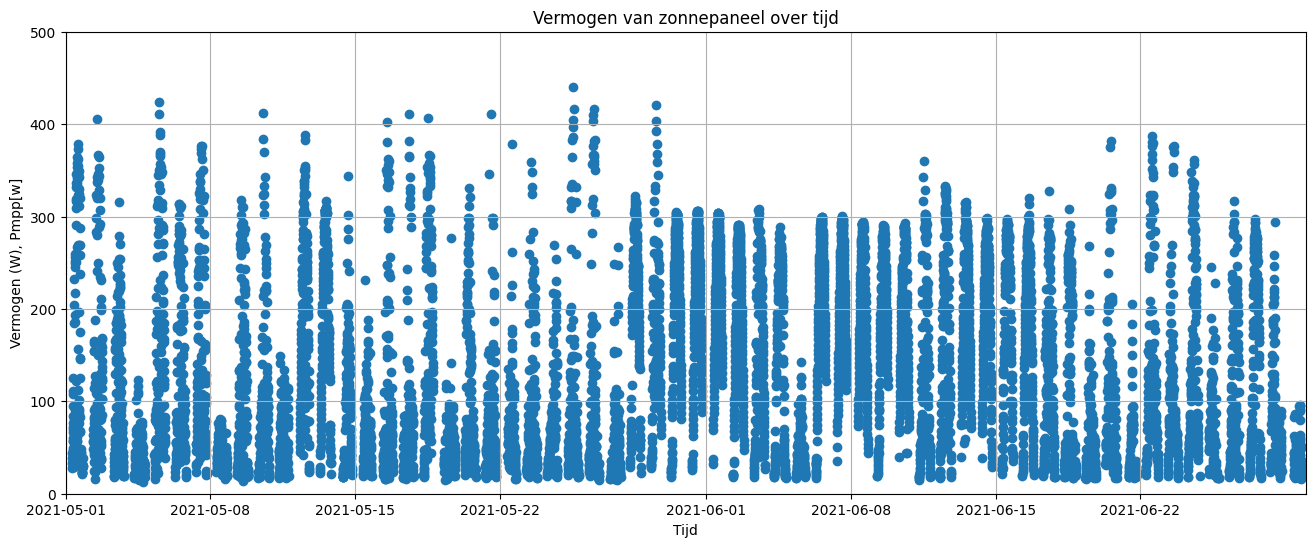

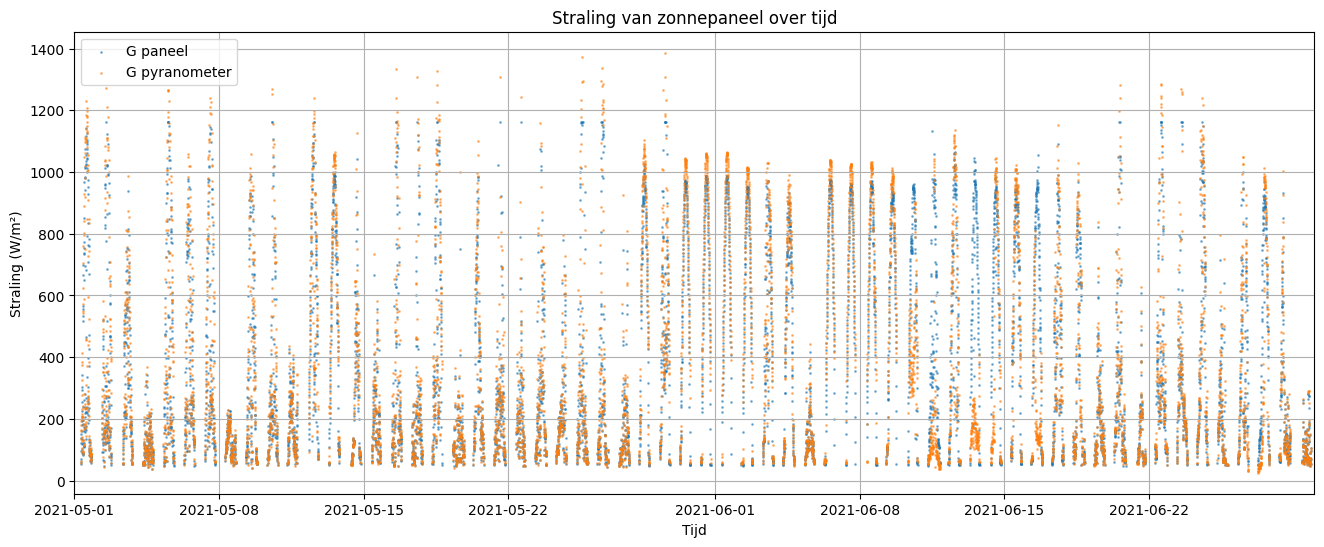

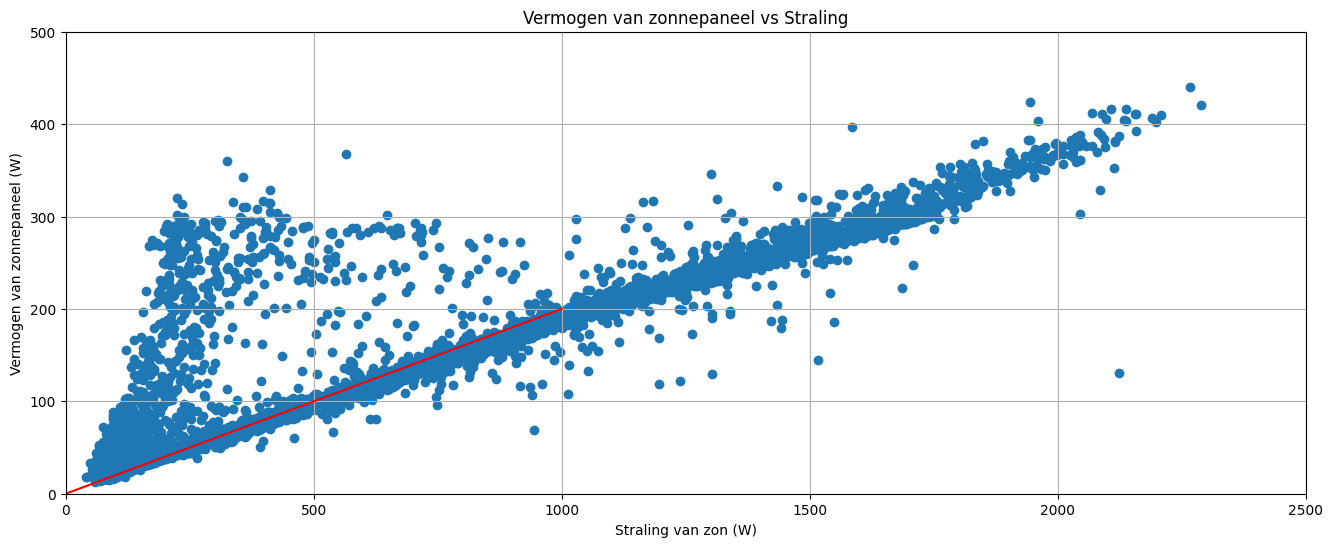

In [32]:
%matplotlib inline
begin = pd.Timestamp('2021-05-01')
end = pd.Timestamp('2021-06-30')

import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))
plt.scatter(synced_df.index, synced_df['Pmpp[W]_3 (Solarpanel parameters)'])
plt.xlabel('Tijd')
plt.ylabel('Vermogen (W), Pmpp[w]')
plt.title('Vermogen van zonnepaneel over tijd')
plt.xlim(begin,end)
plt.ylim(0,500)
plt.grid()

plt.show()
plt.figure(figsize=(16, 6))
#plt.scatter(synced_df.index, synced_df['Pmpp[W]_3 (Solarpanel parameters)'],alpha=0.5,s=0.1)
plt.scatter(synced_df.index, synced_df['G[W/mï½²]_3 (Solarpanel parameters)'],alpha=0.5,s=1,label='G paneel')
plt.scatter(synced_df.index, synced_df['G_pyranometer[W/mï½²]_3 (Solarpanel parameters)'],alpha=0.5,s=1, label='G pyranometer')
plt.xlabel('Tijd')
plt.ylabel('Straling (W/m²)')
plt.title('Straling van zonnepaneel over tijd')
plt.xlim(begin,end)
plt.grid()
plt.legend()
plt.show()

begin_rendement = begin #pd.Timestamp('2021-05-1')
end_rendement = end #pd.Timestamp('2021-06-30')

maandenchecken = synced_df.loc[begin_rendement:end_rendement].copy()

plt.figure(figsize=(16, 6))
plt.scatter(maandenchecken['G_pyranometer[W/mï½²]_3 (Solarpanel parameters)']*1.65,maandenchecken['Pmpp[W]_3 (Solarpanel parameters)'])
x = np.linspace(0, 1000, 100)
plt.plot(x, x*0.20, 'r')
plt.xlabel('Straling van zon (W)')
plt.ylabel('Vermogen van zonnepaneel (W)')
plt.title('Vermogen van zonnepaneel vs Straling')
plt.grid()
plt.xlim(0,2500)
plt.ylim(0,500)
plt.show()

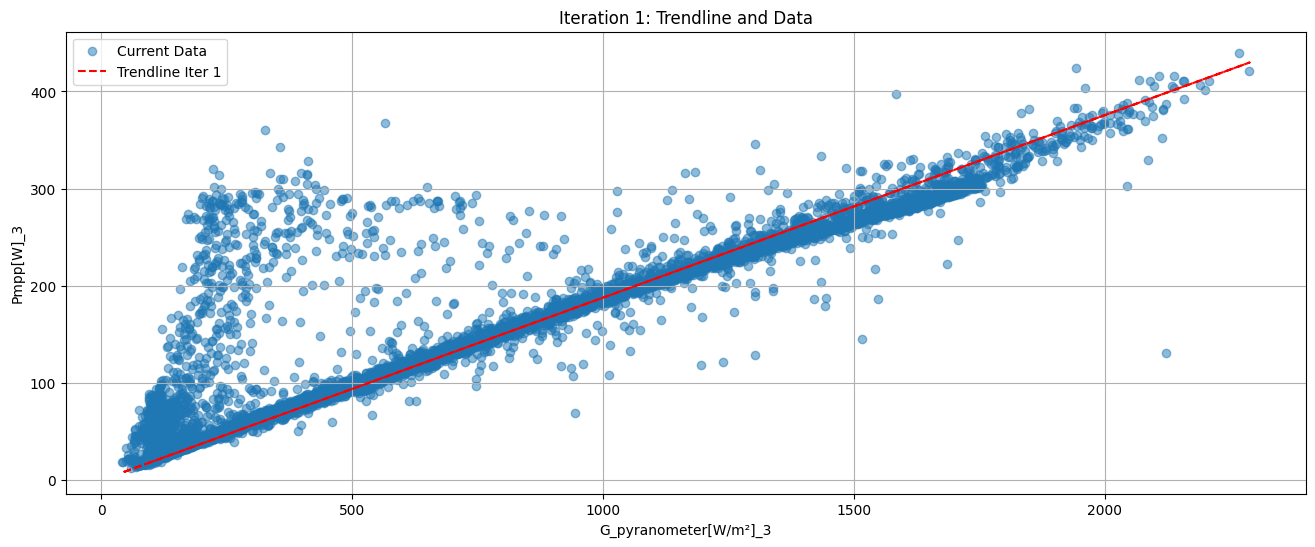

Iteration 1: y = 0.19x
Iteration 1: Removed 326 outliers.


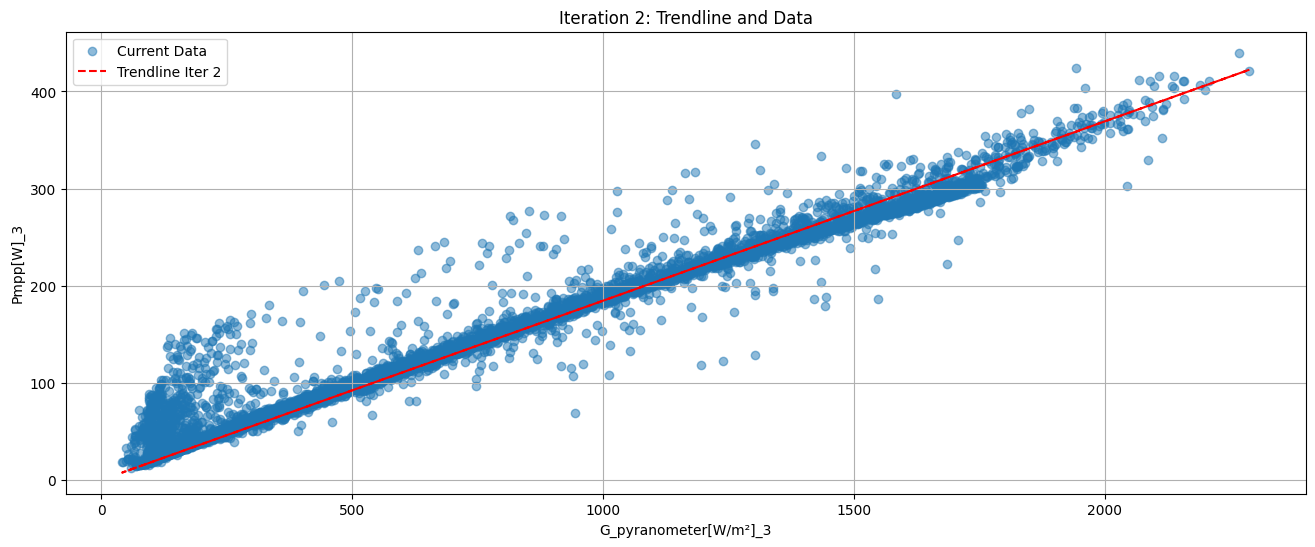

Iteration 2: y = 0.18x
Iteration 2: Removed 262 outliers.


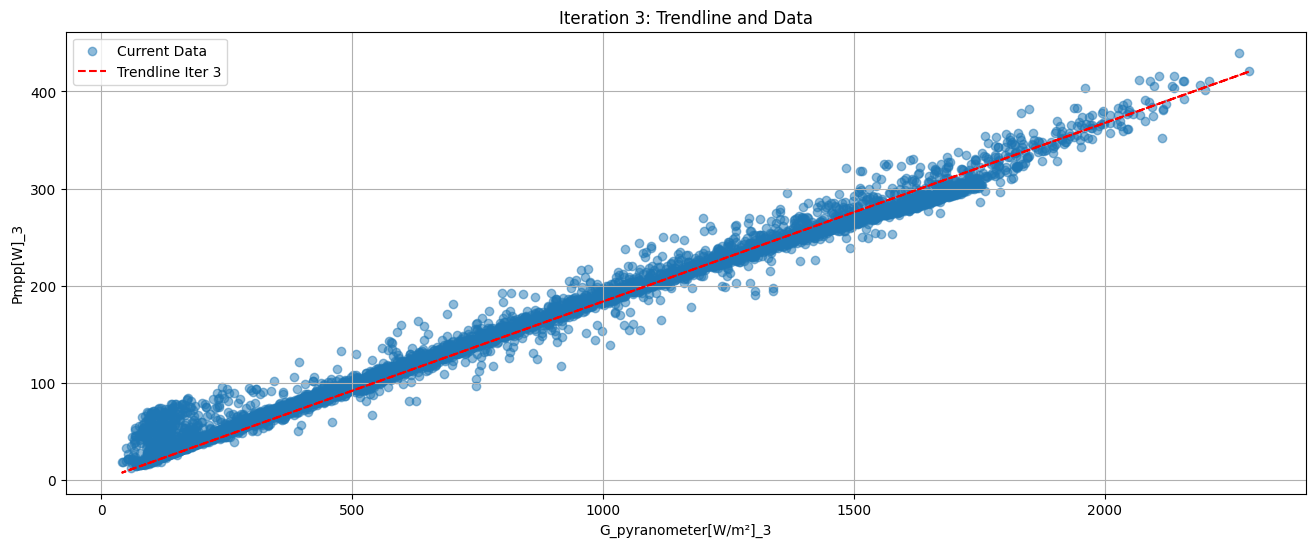

Iteration 3: y = 0.18x
Iteration 3: Removed 254 outliers.


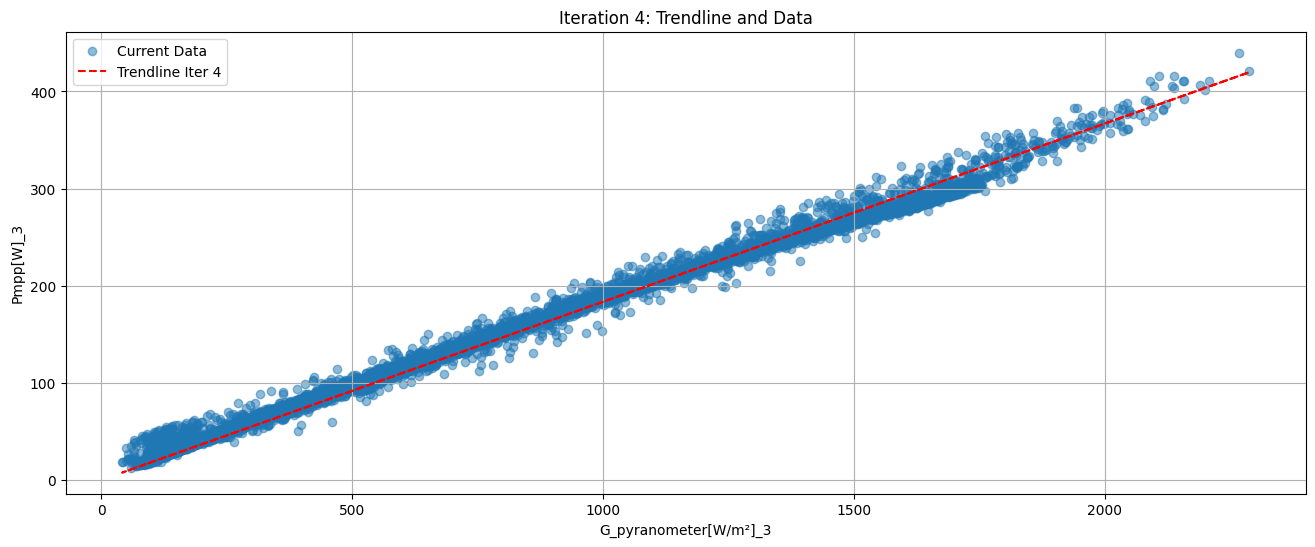

Iteration 4: y = 0.18x
Iteration 4: Removed 130 outliers.


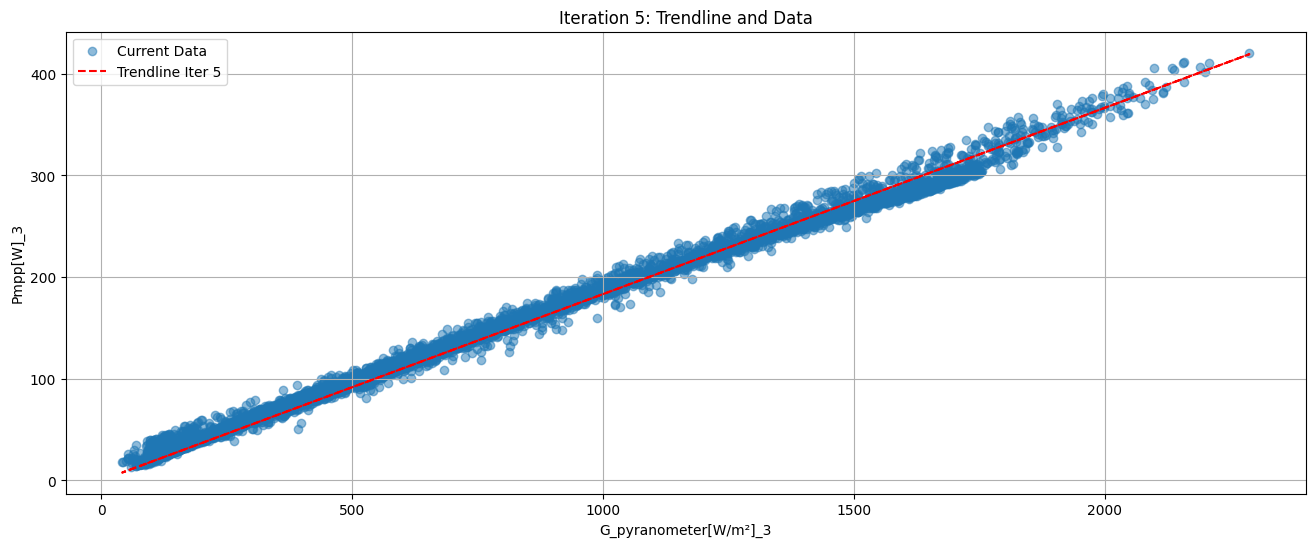

Iteration 5: y = 0.18x
Iteration 5: Removed 51 outliers.


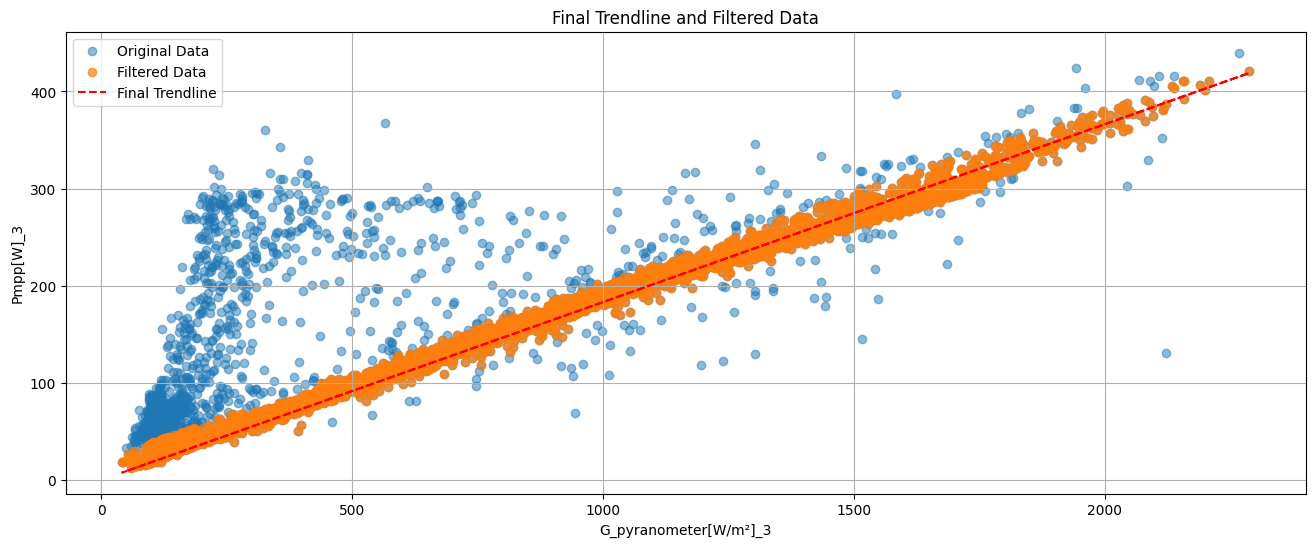

Final Trendline: y = 0.18x


,AbsTime[s],Act Air Density (WeatherStation),Act Wind Direction (WeatherStation),Act Wind Measurement Quality (WeatherStation),Act Wind Speed [km/h] (WeatherStation),Avg Absolute Air Pressure (WeatherStation),Avg Air Temperature (WeatherStation),Avg Dewpoint Temperature (WeatherStation),Avg Relative Humidity (WeatherStation),Avg Wind Speed [km/h] (WeatherStation),...,Temperature [°C] (LAD Sensor 12),Gain (LAD Sensor 12),Integration time (LAD Sensor 12),Year,Month,Day,Weekday,Time,x,y
datetime,,,,,,,,,,,,,,,,,,,,,
2021-05-01 07:40:00,3828843600,1.254171,274.9478,100.0,1.263555,1014.983,7.849673,4.481034,79.27757,0.000000,...,12.5,0.0,192.0,2021,May,1,Saturday,07:40:00,92.070,27.769
2021-05-01 07:45:00,3828843900,1.253278,0.0000,100.0,0.000000,1015.017,7.985149,4.476882,78.52754,0.000000,...,13.2,0.0,192.0,2021,May,1,Saturday,07:45:00,103.950,33.301
2021-05-01 07:50:00,3828844200,1.252931,215.4218,100.0,3.023074,1015.103,8.223319,4.593984,77.90422,1.735225,...,14.2,0.0,192.0,2021,May,1,Saturday,07:50:00,264.165,39.011
2021-05-01 07:55:00,3828844500,1.252172,252.3136,100.0,1.941241,1015.179,8.188429,4.462746,77.37485,1.371645,...,15.8,0.0,192.0,2021,May,1,Saturday,07:55:00,222.255,43.629
2021-05-01 08:00:00,3828844800,1.252115,0.0000,100.0,1.385355,1015.175,8.324501,4.452083,76.60724,1.420834,...,17.0,0.0,192.0,2021,May,1,Saturday,08:00:00,272.415,49.097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-29 19:25:00,3833983500,1.209372,187.6491,100.0,5.572020,1013.254,16.917380,14.182340,83.93651,2.328395,...,20.5,0.0,192.0,2021,June,29,Tuesday,19:25:00,251.460,50.037
2021-06-29 19:30:00,3833983800,1.208927,299.8468,100.0,2.882967,1013.286,17.031370,14.230000,83.59035,3.331224,...,21.5,0.0,192.0,2021,June,29,Tuesday,19:30:00,115.170,23.053
2021-06-29 19:35:00,3833984100,1.208520,238.2829,100.0,6.478311,1013.278,17.091160,14.268260,83.48077,1.996748,...,21.8,0.0,192.0,2021,June,29,Tuesday,19:35:00,173.580,35.219


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `synced_df` is already defined
begin_rendement = begin  # Replace `begin` with your actual start timestamp
end_rendement = end      # Replace `end` with your actual end timestamp

# Extract data for the specified time range
maandenchecken = synced_df.loc[begin_rendement:end_rendement].copy()

# Extract x and y values
x = maandenchecken['G_pyranometer[W/mï½²]_3 (Solarpanel parameters)'] * 1.65
y = maandenchecken['Pmpp[W]_3 (Solarpanel parameters)']

# Add x and y columns to maandenchecken for tracking
maandenchecken['x'] = x
maandenchecken['y'] = y

# Function to iteratively fit and remove outliers (slope-only)
def iterative_fit_and_filter(data, x_col, y_col, threshold=3, max_iterations=5):
    x = pd.to_numeric(data[x_col], errors='coerce')
    y = pd.to_numeric(data[y_col], errors='coerce')

    # Remove initial NaN values
    mask = ~x.isna() & ~y.isna()
    x = x[mask]
    y = y[mask]
    filtered_data = data[mask].copy()

    for iteration in range(max_iterations):
        # Fit a slope-only line (zero-intercept)
        slope = np.sum(x * y) / np.sum(x ** 2)
        
        # Calculate residuals
        residuals = y - (slope * x)
        std_residuals = np.std(residuals)

        # Identify points far from the trendline
        outliers = np.abs(residuals) > threshold * std_residuals

        if not outliers.any():
            print(f"No more outliers found after {iteration} iterations.")
            break

        # Plot intermediate results
        plt.figure(figsize=(16, 6))
        plt.scatter(x, y, alpha=0.5, label='Current Data')
        plt.plot(x, slope * x, "r--", label=f'Trendline Iter {iteration + 1}')
        plt.xlabel('G_pyranometer[W/m²]_3')
        plt.ylabel('Pmpp[W]_3')
        plt.title(f'Iteration {iteration + 1}: Trendline and Data')
        plt.legend()
        plt.grid()
        plt.show()

        # Print equation of the line
        print(f"Iteration {iteration + 1}: y = {slope:.2f}x")

        # Remove outliers
        filtered_mask = ~outliers
        x = x[filtered_mask]
        y = y[filtered_mask]
        filtered_data = filtered_data[filtered_mask].copy()

        print(f"Iteration {iteration + 1}: Removed {outliers.sum()} outliers.")

    # Final fit (slope-only)
    final_slope = np.sum(x * y) / np.sum(x ** 2)

    # Plot final results
    plt.figure(figsize=(16, 6))
    plt.scatter(data[x_col], data[y_col], alpha=0.5, label='Original Data')
    plt.scatter(x, y, alpha=0.7, label='Filtered Data')
    plt.plot(x, final_slope * x, "r--", label='Final Trendline')
    plt.xlabel('G_pyranometer[W/m²]_3')
    plt.ylabel('Pmpp[W]_3')
    plt.title('Final Trendline and Filtered Data')
    plt.legend()
    plt.grid()
    plt.show()

    # Print final equation of the line
    print(f"Final Trendline: y = {final_slope:.2f}x")

    return filtered_data, final_slope

# Apply the function
filtered_df, final_slope = iterative_fit_and_filter(maandenchecken, 'x', 'y')

# Display filtered DataFrame
filtered_df


In [34]:
import pvlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def simulatie_runnen(
    df,
    kalibratie_waarde=1.32,
    locatie_naam="amolf",
    latitude=52.3676,
    longitude=4.9041,
    timezone="Europe/Amsterdam",
    surface_tilt=45,
    surface_azimuth=180,
    albedo=0.2
):
    # PVWatts parameters
    pdc0 = 255
    gamma_pdc = -0.0045
    
    # Set up location
    location = pvlib.location.Location(
        latitude=latitude, longitude=longitude, tz=timezone, name=locatie_naam
    )
    
    # Copy the input DataFrame
    data = df.copy()
    
    # Calculate solar position
    solar_position = location.get_solarposition(data.index)
    
    # Calculate DNI and DHI from GHI
    dni = pvlib.irradiance.dirint(
        ghi=data["G_pyranometer[W/mï½²]_3 (Solarpanel parameters)"],
        solar_zenith=solar_position["apparent_zenith"],
        times=data.index
    )
    dhi = data["G_pyranometer[W/mï½²]_3 (Solarpanel parameters)"] - dni * np.cos(np.radians(solar_position["apparent_zenith"]))
    
    # Calculate POA irradiance using panel tilt and azimuth
    poa_irradiance = pvlib.irradiance.get_total_irradiance(
        surface_tilt=surface_tilt,
        surface_azimuth=surface_azimuth,
        solar_zenith=solar_position["apparent_zenith"],
        solar_azimuth=solar_position["azimuth"],
        dni=dni,
        ghi=data["G_pyranometer[W/mï½²]_3 (Solarpanel parameters)"],
        dhi=dhi,
        albedo=albedo
    )
    
    # Add POA irradiance to weather data
    data["poa_irradiance"] = poa_irradiance["poa_global"]
    
    # Temperature model parameters for open-rack glass-glass panels
    from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
    temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS["sapm"]["open_rack_glass_glass"]
    
    # Define the PV system
    system = pvlib.pvsystem.PVSystem(
        surface_tilt=surface_tilt,
        surface_azimuth=surface_azimuth,
        module_parameters={"pdc0": pdc0, "gamma_pdc": gamma_pdc},
        inverter_parameters={"pdc0": pdc0},
        temperature_model_parameters=temperature_model_parameters
    )
    
    # Weather data preparation
    weather = pd.DataFrame(index=data.index)
    weather["ghi"] = data["G_pyranometer[W/mï½²]_3 (Solarpanel parameters)"]
    weather["dni"] = dni
    weather["dhi"] = dhi
    weather["temp_air"] = data.get("Avg Air Temperature (WeatherStation)", 20.0)
    weather["wind_speed"] = data.get("Avg Wind Speed [km/h] (WeatherStation)", 3.6) / 3.6
    weather["poa_global"] = data["poa_irradiance"]
    
    # Run the model chain
    mc = pvlib.modelchain.ModelChain(
        system, location, dc_model="pvwatts", ac_model="pvwatts",
        aoi_model="physical", spectral_model="no_loss"
    )
    mc.run_model(weather)
    
    # Calibrate DC output
    dc_power = mc.results.dc * kalibratie_waarde
    return dc_power

In [35]:
dc_vermogen_0_azimuth = simulatie_runnen(filtered_df,surface_azimuth=180, surface_tilt=0)

# Optimazing the solar panels at Amolf. 

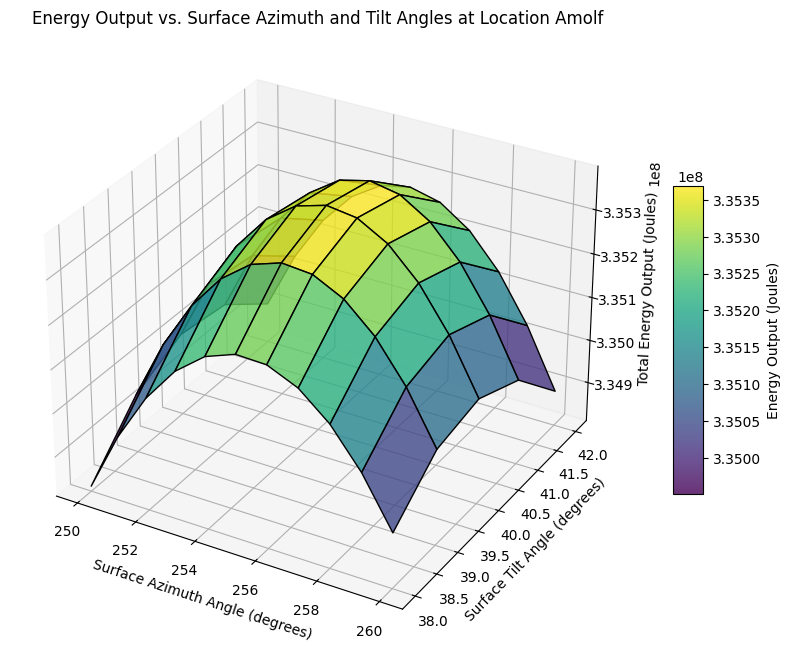

In [40]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define ranges for azimuth and tilt angles
azimuths = np.arange(250, 261, 1)  # Azimuth angles from 0 to 360 degrees in 30-degree steps
tilts = np.arange(38, 43, 1)      # Tilt angles from 0 to 90 degrees in 10-degree steps

# Create a grid for azimuth and tilt
azimuth_grid, tilt_grid = np.meshgrid(azimuths, tilts)

# Placeholder for energy output
energy_output = np.zeros_like(azimuth_grid, dtype=float)

# Compute energy output for each combination of azimuth and tilt
for i, azimuth in enumerate(azimuths):
    for j, tilt in enumerate(tilts):
        # Run simulation for each azimuth-tilt combination
        dc_power_df = simulatie_runnen(filtered_df, surface_azimuth=azimuth, surface_tilt=tilt)
        
        # Ensure the result is in DataFrame format
        if isinstance(dc_power_df, str):
            from io import StringIO
            dc_power_df = pd.read_csv(StringIO(dc_power_df))
        
        # Compute total energy (sum of power over time in Joules)
        total_energy = dc_power_df.sum() * 60 * 5  # Assuming 5-minute intervals, convert to Joules
        total_energy_value = total_energy.values[0] if isinstance(total_energy, pd.Series) else total_energy
        
        # Store the result in the energy output grid
        energy_output[j, i] = total_energy_value

# Create a 3D surface plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(
    azimuth_grid, tilt_grid, energy_output, cmap="viridis", edgecolor="k", alpha=0.8
)

# Add labels and title
ax.set_xlabel("Surface Azimuth Angle (degrees)")
ax.set_ylabel("Surface Tilt Angle (degrees)")
ax.set_zlabel("Total Energy Output (Joules)")
ax.set_title("Energy Output vs. Surface Azimuth and Tilt Angles at Location Amolf")

# Add a color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label="Energy Output (Joules)")

# Show the plot
plt.show()


In [42]:
%matplotlib qt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define ranges for azimuth and tilt angles
azimuths = np.arange(0, 360, 30)  # Azimuth angles from 0 to 360 degrees in 30-degree steps
tilts = np.arange(0, 90, 10)      # Tilt angles from 0 to 90 degrees in 10-degree steps

# Create a grid for azimuth and tilt
azimuth_grid, tilt_grid = np.meshgrid(azimuths, tilts)

# Placeholder for energy output
energy_output = np.zeros_like(azimuth_grid, dtype=float)

# Compute energy output for each combination of azimuth and tilt
for i, azimuth in enumerate(azimuths):
    for j, tilt in enumerate(tilts):
        # Run simulation for each azimuth-tilt combination
        dc_power_df = simulatie_runnen(filtered_df, surface_azimuth=azimuth, surface_tilt=tilt)
        
        # Ensure the result is in DataFrame format
        if isinstance(dc_power_df, str):
            from io import StringIO
            dc_power_df = pd.read_csv(StringIO(dc_power_df))
        
        # Compute total energy (sum of power over time in Joules)
        total_energy = dc_power_df.sum() * 60 * 5  # Assuming 5-minute intervals, convert to Joules
        total_energy_value = total_energy.values[0] if isinstance(total_energy, pd.Series) else total_energy
        
        # Store the result in the energy output grid
        energy_output[j, i] = total_energy_value

# Create a 3D surface plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(
    azimuth_grid, tilt_grid, energy_output, cmap="viridis", edgecolor="k", alpha=0.8
)

# Add labels and title
ax.set_xlabel("Surface Azimuth Angle (degrees)")
ax.set_ylabel("Surface Tilt Angle (degrees)")
ax.set_zlabel("Total Energy Output (Joules)")
ax.set_title("Energy Output vs. Surface Azimuth and Tilt Angles at Location Amolf")

# Add a color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label="Energy Output (Joules)")

# Show the plot
plt.show()


# Optimizing the solar panels at the capitols of the Netherlands

In [45]:
import numpy as np
import pandas as pd

# Define capitals and coordinates for each province in the Netherlands
province_locations = {
    "Drenthe": {"city": "Assen", "latitude": 52.9929, "longitude": 6.5642},
    "Flevoland": {"city": "Lelystad", "latitude": 52.5185, "longitude": 5.4714},
    "Friesland": {"city": "Leeuwarden", "latitude": 53.2012, "longitude": 5.7999},
    "Gelderland": {"city": "Arnhem", "latitude": 51.9851, "longitude": 5.8987},
    "Groningen": {"city": "Groningen", "latitude": 53.2194, "longitude": 6.5665},
    "Limburg": {"city": "Maastricht", "latitude": 50.8514, "longitude": 5.6900},
    "North Brabant": {"city": "Den Bosch", "latitude": 51.6978, "longitude": 5.3037},
    "North Holland": {"city": "Haarlem", "latitude": 52.3874, "longitude": 4.6462},
    "Overijssel": {"city": "Zwolle", "latitude": 52.5168, "longitude": 6.0830},
    "South Holland": {"city": "The Hague", "latitude": 52.0705, "longitude": 4.3007},
    "Utrecht": {"city": "Utrecht", "latitude": 52.0907, "longitude": 5.1214},
    "Zeeland": {"city": "Middelburg", "latitude": 51.4988, "longitude": 3.6105},
}

# Refined ranges for tilt and azimuth
tilts = np.arange(38, 43, 1)  # Tilt angles from 38 to 42 degrees
azimuths = np.arange(250, 261, 1)  # Azimuth angles from 250 to 260 degrees

# Create a grid for azimuth and tilt
azimuth_grid, tilt_grid = np.meshgrid(azimuths, tilts)

# Prepare results table
results = []

# Iterate through each province
for province, location in province_locations.items():
    latitude = location["latitude"]
    longitude = location["longitude"]
    
    # Placeholder for energy output
    energy_output = np.zeros_like(azimuth_grid, dtype=float)
    
    # Simulate for each combination of azimuth and tilt
    for i, azimuth in enumerate(azimuths):
        for j, tilt in enumerate(tilts):
            # Run the simulation with updated location
            dc_power_df = simulatie_runnen(
                filtered_df,
                surface_azimuth=azimuth,
                surface_tilt=tilt,
                latitude=latitude,
                longitude=longitude,
            )
            
            # Ensure the result is in DataFrame format
            if isinstance(dc_power_df, str):
                from io import StringIO
                dc_power_df = pd.read_csv(StringIO(dc_power_df))
            
            # Compute total energy (sum of power over time in Joules)
            total_energy = dc_power_df.sum() * 60 * 5  # Assuming 5-minute intervals
            total_energy_value = total_energy.values[0] if isinstance(total_energy, pd.Series) else total_energy
            
            # Store the result in the energy output grid
            energy_output[j, i] = total_energy_value
    
    # Find optimal tilt and azimuth
    max_energy_index = np.unravel_index(np.argmax(energy_output), energy_output.shape)
    optimal_tilt = tilts[max_energy_index[0]]
    optimal_azimuth = azimuths[max_energy_index[1]]
    max_energy = energy_output[max_energy_index]
    
    # Append results
    results.append({
        "Province": province,
        "City": location["city"],
        "Optimal Tilt (degrees)": optimal_tilt,
        "Optimal Azimuth (degrees)": optimal_azimuth,
        "Maximum Energy Output (Joules)": max_energy,
    })

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)

# Display the results
results_df

,Province,City,Optimal Tilt (degrees),Optimal Azimuth (degrees),Maximum Energy Output (Joules)
0,Drenthe,Assen,41,256,3.392178e+08
1,Flevoland,Lelystad,41,255,3.365611e+08
2,Friesland,Leeuwarden,41,255,3.377485e+08
3,Gelderland,Arnhem,41,257,3.373919e+08
4,Groningen,Groningen,41,256,3.392131e+08
5,Limburg,Maastricht,40,258,3.363482e+08
6,North Brabant,Den Bosch,40,256,3.359607e+08
7,North Holland,Haarlem,40,255,3.348773e+08
8,Overijssel,Zwolle,41,256,3.379498e+08
9,South Holland,The Hague,40,255,3.340557e+08


# Making a grid over the Netherlands

In [48]:
import numpy as np
import pandas as pd

# Define latitude and longitude range for the Netherlands
# Custom grid with 6 height points and 5 width points
lat_points_custom = 6  # Height
lon_points_custom = 5  # Width
nl_lat_min, nl_lat_max = 50.75, 53.55
nl_lon_min, nl_lon_max = 3.36, 7.22

# Generate the custom grid
latitudes = np.linspace(nl_lat_min, nl_lat_max, lat_points_custom)
longitudes = np.linspace(nl_lon_min, nl_lon_max, lon_points_custom)

# Define tilt and azimuth ranges
tilts = np.arange(38, 43, 1)  # Tilt angles from 38 to 42 degrees
azimuths = np.arange(250, 261, 1)  # Azimuth angles from 250 to 260 degrees

# Create a grid for latitude and longitude
lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)

# Placeholder for results
grid_results = []

# Iterate over each grid point
for i, lat in enumerate(latitudes):
    for j, lon in enumerate(longitudes):
        # Placeholder for energy output for each grid point
        energy_output = np.zeros((len(tilts), len(azimuths)))

        # Simulate energy output for each tilt-azimuth combination
        for t, tilt in enumerate(tilts):
            for a, azimuth in enumerate(azimuths):
                # Replace this with your simulation function
                dc_power_df = simulatie_runnen(
                    filtered_df,
                    surface_azimuth=azimuth,
                    surface_tilt=tilt,
                    latitude=lat,
                    longitude=lon,
                )
                
                # Ensure the result is in DataFrame format
                if isinstance(dc_power_df, str):
                    from io import StringIO
                    dc_power_df = pd.read_csv(StringIO(dc_power_df))
                
                # Compute total energy (sum of power over time in Joules)
                total_energy = dc_power_df.sum() * 60 * 5  # Assuming 5-minute intervals
                total_energy_value = total_energy.values[0] if isinstance(total_energy, pd.Series) else total_energy
                
                # Store the energy output
                energy_output[t, a] = total_energy_value
        
        # Find the optimal tilt and azimuth for maximum energy output
        max_energy_index = np.unravel_index(np.argmax(energy_output), energy_output.shape)
        optimal_tilt = tilts[max_energy_index[0]]
        optimal_azimuth = azimuths[max_energy_index[1]]
        max_energy = energy_output[max_energy_index]
        
        # Append the results for this grid point
        grid_results.append({
            "Latitude": lat,
            "Longitude": lon,
            "Optimal Tilt (degrees)": optimal_tilt,
            "Optimal Azimuth (degrees)": optimal_azimuth,
            "Maximum Energy Output (Joules)": max_energy,
        })

# Convert the results to a DataFrame
grid_results_df = pd.DataFrame(grid_results)

# Save the grid results to a CSV file for analysis or visualization
grid_results_df.to_csv("Netherlands_Energy_Grid_Results.csv", index=False)

# Display the results DataFrame
grid_results_df


,Latitude,Longitude,Optimal Tilt (degrees),Optimal Azimuth (degrees),Maximum Energy Output (Joules)
0,50.75,3.360,39,255,3.314199e+08
1,50.75,4.325,40,256,3.334327e+08
2,50.75,5.290,40,257,3.354660e+08
3,50.75,6.255,41,258,3.374322e+08
4,50.75,7.220,41,259,3.394539e+08
5,51.31,3.360,39,255,3.316709e+08
6,51.31,4.325,40,256,3.336561e+08
7,51.31,5.290,40,257,3.356171e+08
8,51.31,6.255,41,258,3.377328e+08
9,51.31,7.220,42,259,3.397693e+08


# Plotting a heatmap of the netherlands of the Solar Energy Output

In [53]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point
from scipy.interpolate import griddata

# Load the grid results from the provided CSV
grid_results_df = pd.read_csv('Netherlands_Energy_Grid_Results.csv')

# Extract data for plotting
lon = grid_results_df["Longitude"].values
lat = grid_results_df["Latitude"].values
energy_output = grid_results_df["Maximum Energy Output (Joules)"].values

# Create a grid for longitude and latitude
num_points = 300  # Number of interpolation points for better resolution
lon_grid = np.linspace(min(lon), max(lon), num_points)
lat_grid = np.linspace(min(lat), max(lat), num_points)
lon_grid, lat_grid = np.meshgrid(lon_grid, lat_grid)

# Interpolate the energy output onto the grid
grid_values = griddata(
    (lon, lat), energy_output, (lon_grid, lat_grid), method="linear"
)

# Load the countries shapefile
shapefile_path = "ne_10m_admin_0_countries.shp"  # Path to the countries shapefile
countries = gpd.read_file(shapefile_path)

# Filter to the Netherlands
netherlands = countries[countries["SOVEREIGNT"] == "Netherlands"]

# Ensure the shapefile and grid data use the same CRS
if netherlands.crs.to_string() != "EPSG:4326":
    netherlands = netherlands.to_crs("EPSG:4326")  # Reproject to WGS84 if needed

# Combine all geometries into one land polygon
land_polygon = netherlands.geometry.unary_union

# Create a mask: Points inside the land area of the Netherlands
mask = np.array([
    Point(lon, lat).within(land_polygon)
    for lon, lat in zip(lon_grid.ravel(), lat_grid.ravel())
]).reshape(lon_grid.shape)

# Apply the land mask to the interpolated grid
grid_values[~mask] = np.nan  # Set values outside land to NaN

# Plot the heatmap over the Netherlands
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([3.2, 7.4, 50.5, 54.0], crs=ccrs.PlateCarree())  # Extent for the Netherlands

# Add natural features to the map
ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black")
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")
ax.add_feature(cfeature.LAKES, edgecolor="blue", facecolor="lightblue")

# Overlay the interpolated heatmap on land areas
heatmap = ax.pcolormesh(
    lon_grid,
    lat_grid,
    grid_values,
    cmap="viridis",
    shading="nearest",
    transform=ccrs.PlateCarree(),
)

# Add a colorbar
plt.colorbar(heatmap, ax=ax, orientation="vertical", label="Maximum Energy Output (Joules)")

# Add title
ax.set_title("Energy Output Across the Netherlands (Land Only)")
plt.show()


C:\Users\quinc\AppData\Local\Temp\ipykernel_21128\823242708.py:41: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  land_polygon = netherlands.geometry.unary_union
